## Setup

In [23]:
!pip install tflite-support


     |████████████████████████████████| 1.1 MB 5.3 MB/s 
     |████████████████████████████████| 211 kB 50.3 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    

Default GPU Device: /device:GPU:0


## Loading and preparing train and test data

We use "Sensors Activity Dataset" by Shoaib et al. which is available for download from [here](https://www.utwente.nl/en/eemcs/ps/research/dataset/).
There are 7 activities in this dataset: Biking, Downstairs, Jogging, Sitting, Standing, Upstairs, Walking. 
There were ten participants involved in data collection experiment who performed  each of these activities for 3-4 minutes.
All ten participants were male, between the ages of 25 and 30. 
Each of these participants was equipped with five smartphones on five body positions: 

1. One in their right jean’s pocket. 
2. One in their left jean’s pocket.
3. One on belt position towards the right leg using a belt clipper.
4. One on the right upper arm. 
5. One on the right wrist.

The data was collected for an accelerometer, a gyroscope, a magnetometer, and a linear acceleration sensor. 
Each csv file contains data for each participant's seven physical activities for all five positions. 

Notation in these files: 

Accelerometer ( Ax = x-axis, Ay = y-axis, Az= Z-aixs)   
Linear Acceleration Sensor ( Lx = x-axis, Ly = y axis, Lz= Z-aixs)   
Gyroscope ( Gx = x-axis, Gy = y-axis, Gz= Z-aixs)   
Magnetometer ( Mx = x-axis, My = y-axis, Mz= Z-aixs) 

In [4]:
# Download dataset
! wget https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar -P ../data/

# Extract dataset using unrar
!pip install unrar
!unrar e ../data/sensors-activity-recognition-dataset-shoaib.rar ../data/


--2022-02-22 06:11:15--  https://www.utwente.nl/en/eemcs/ps/dataset-folder/sensors-activity-recognition-dataset-shoaib.rar
Resolving www.utwente.nl (www.utwente.nl)... 130.89.3.249, 2001:67c:2564:a102::1:1
Connecting to www.utwente.nl (www.utwente.nl)|130.89.3.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100080442 (95M) [application/x-rar-compressed]
Saving to: ‘../data/sensors-activity-recognition-dataset-shoaib.rar.1’

sensors-activity-re 100%[===================>]  95.44M  22.9MB/s    in 4.2s    

2022-02-22 06:11:20 (22.9 MB/s) - ‘../data/sensors-activity-recognition-dataset-shoaib.rar.1’ saved [100080442/100080442]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ../data/sensors-activity-recognition-dataset-shoaib.rar


Would you like to replace the existing file ../data/Participant_1.csv
32372897 bytes, modified on 2014-03-31 14:45
with a new one
32372897 bytes, modified on 2014-03-31 14:45

[Y]es, [N]o, [A]ll,

## Loading and preparing train and test data

We load all 10 participants data into a single dataframe:


In [5]:
df = pd.DataFrame()
for i in range(10):
    df_tmp = pd.read_csv('../data/Participant_' + str(i+1) + '.csv', header=1)
    df = pd.concat([df, df_tmp])

# View top 5 rows of dataframe
df.head()


,time_stamp,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,Mx,My,Mz,Unnamed: 13,time_stamp.1,Ax.1,Ay.1,Az.1,Lx.1,Ly.1,Lz.1,Gx.1,Gy.1,Gz.1,Mx.1,My.1,Mz.1,Unnamed: 27,time_stamp.2,Ax.2,Ay.2,Az.2,Lx.2,Ly.2,Lz.2,Gx.2,Gy.2,Gz.2,Mx.2,My.2,Mz.2,Unnamed: 41,time_stamp.3,Ax.3,Ay.3,Az.3,Lx.3,Ly.3,Lz.3,Gx.3,Gy.3,Gz.3,Mx.3,My.3,Mz.3,Unnamed: 55,time_stamp.4,Ax.4,Ay.4,Az.4,Lx.4,Ly.4,Lz.4,Gx.4,Gy.4,Gz.4,Mx.4,My.4,Mz.4,Unnamed: 69
0,1.390000e+12,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,12.72,40.74,-6.00,NaN,1.390000e+12,-1.19860,-13.852,3.7865,-1.76980,-4.0625,3.89850,-3.6255,1.07390,0.13622,18.84,55.92,-6.72,NaN,1.390000e+12,0.17706,-10.569,1.8251,-7.5051,-4.7736,-0.062476,-0.36652,1.27060,-0.52412,-30.30,31.08,3.96,NaN,1.390000e+12,2.79220,-12.5720,-4.3177,-0.098712,-3.385700,-2.46480,0.021075,1.02990,1.22690,-18.72,31.74,17.82,NaN,1.390000e+12,4.3177,-2.36990,-0.43585,-5.3574,-0.95749,0.318860,0.52565,-0.18815,0.285880,-22.20,6.48,4.56,walking
1,1.390000e+12,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,12.54,40.74,-6.78,NaN,1.390000e+12,-2.38360,-16.590,2.9965,-2.70250,-6.7890,2.86820,-3.4899,0.39034,0.40073,18.60,55.86,-6.06,NaN,1.390000e+12,0.16344,-12.190,2.0703,-7.3573,-6.2618,-0.042442,-0.54459,1.28070,0.34025,-31.02,29.88,3.36,NaN,1.390000e+12,2.38360,-10.9920,-4.6037,-0.404440,-1.774500,-2.74830,0.201890,0.53573,1.32280,-18.84,31.74,17.70,NaN,1.390000e+12,5.1213,-2.19290,-0.70826,-4.5352,-0.67629,0.081656,0.43616,0.16371,0.198230,-21.90,7.14,5.34,walking
2,1.390000e+12,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,12.42,40.68,-8.10,NaN,1.390000e+12,-4.63090,-16.603,2.0703,-4.34550,-6.8081,1.68890,-3.3851,-1.99200,1.12280,18.72,55.80,-4.26,NaN,1.390000e+12,0.57205,-12.626,2.2474,-6.7655,-6.5138,0.017921,-0.70952,1.15820,0.99724,-31.26,29.22,3.24,NaN,1.390000e+12,1.56630,-9.0848,-4.5764,-1.003600,0.201530,-2.75150,0.287720,0.10049,1.20710,-19.02,31.68,17.52,NaN,1.390000e+12,5.6116,-2.12480,-1.26670,-4.0408,-0.55974,-0.523690,0.32284,0.43127,0.211970,-21.60,7.50,5.64,walking
3,1.390000e+12,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,12.30,40.74,-8.52,NaN,1.390000e+12,-4.78070,-16.453,1.1577,-4.19540,-6.6731,0.74084,-3.1017,-3.04390,0.79138,18.84,55.62,-3.12,NaN,1.390000e+12,1.21220,-12.476,2.2882,-5.9716,-6.1990,0.016760,-0.78191,1.10200,1.33380,-31.44,28.80,3.24,NaN,1.390000e+12,-0.61292,-8.5263,-2.9284,-2.827100,0.859490,-1.14670,0.175930,-0.21441,0.90469,-18.96,31.86,17.22,NaN,1.390000e+12,6.0611,-1.47100,-2.47890,-3.5908,0.15795,-1.880200,0.20403,0.72846,0.164930,-21.12,8.40,6.12,walking
4,1.390000e+12,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,12.24,40.80,-8.88,NaN,1.390000e+12,-0.92618,-12.190,-1.0624,-0.18116,-2.4144,-1.28500,-2.7587,-4.46020,0.69364,19.38,55.44,-0.84,NaN,1.390000e+12,2.24740,-11.387,1.9886,-4.6603,-4.8230,-0.329740,-0.82436,0.90561,2.15600,-31.56,28.32,3.30,NaN,1.390000e+12,-1.18500,-9.3436,-2.2337,-3.209900,0.085583,-0.45569,-0.033292,-0.48625,0.60720,-18.84,32.10,17.04,NaN,1.390000e+12,7.7091,-0.77636,-3.54130,-1.9450,0.85796,-2.995300,0.09896,0.94379,0.064752,-20.94,8.70,6.30,walking


Now we split data into train and test sets (80% train, 20% test):


In [6]:
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point, :]
test_data = df.iloc[split_point:, :]

print("Number of train spamples: ", len(train_data))
print("Number of test spamples: ", len(test_data))


Number of train spamples:  504000
Number of test spamples:  126000


As we only use right pocket's and left pocket's data, we should concatenate those into a single data frame:

In [7]:
def concat(data):
    
    # Select left pocket data
    left_pocket = data.iloc[:,1:10]
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    left_pocket["MA"] = np.sqrt(np.square(left_pocket['Ax']) + np.square(left_pocket['Ay']) + np.square(left_pocket['Az']))
    left_pocket["ML"] = np.sqrt(np.square(left_pocket['Lx']) + np.square(left_pocket['Ly']) + np.square(left_pocket['Lz']))
    left_pocket["MG"] = np.sqrt(np.square(left_pocket['Gx']) + np.square(left_pocket['Gy']) + np.square(left_pocket['Gz']))
    

    # Select right pocket data
    right_pocket = data.iloc[:,15:24]
    right_pocket.columns=['Ax', 'Ay', 'Az', 'Lx', 'Ly', 'Lz', 'Gx', 'Gy', 'Gz']
    
    #Square root of sum of squares of accelerometer, linear acceleration and gyroscope data
    right_pocket["MA"] = np.sqrt(np.square(right_pocket['Ax']) + np.square(right_pocket['Ay']) + np.square(right_pocket['Az']))
    right_pocket["ML"] = np.sqrt(np.square(right_pocket['Lx']) + np.square(right_pocket['Ly']) + np.square(right_pocket['Lz']))
    right_pocket["MG"] = np.sqrt(np.square(right_pocket['Gx']) + np.square(right_pocket['Gy']) + np.square(right_pocket['Gz']))

    
    # Extract labels 
    labels = data.iloc[:, 69] 
    labels = labels.to_frame()
    labels.columns=['Activity_Label']
    labels = pd.concat([labels]*2, ignore_index=True)
    #replace typo 'upsatirs' with upstairs! 
    labels.loc[(labels['Activity_Label'] == 'upsatirs')] = 'upstairs'
    
    #Concatenate left pocket and right pocket data into a single data frame (we only use left pocket and right pocket data)
    frames = [left_pocket, right_pocket]
    df = pd.concat(frames)
   
    return df, labels

# Generate input data and labels
train_X, train_y = concat(train_data)
test_X, test_y = concat(test_data)


In [8]:
train_X.head()

,Ax,Ay,Az,Lx,Ly,Lz,Gx,Gy,Gz,MA,ML,MG
0,-1.81150,-14.873,-1.34840,-1.26910,-5.1057,-0.66445,-0.53206,-3.18690,0.23976,15.043465,5.302856,3.239893
1,0.24517,-14.070,-0.84446,0.70147,-4.2969,-0.17199,-0.25229,-1.79660,0.40745,14.097451,4.357177,1.859419
2,-0.57205,-14.628,-1.75700,-0.21760,-4.8531,-1.05650,-1.04920,0.29138,0.29230,14.744242,4.971531,1.127458
3,-0.69464,-12.939,-3.09180,-0.32273,-3.1786,-2.21970,-2.37200,1.00820,0.34972,13.321392,3.890337,2.600991
4,0.87170,-12.000,-1.56630,1.13740,-2.2390,-0.65476,-2.79010,0.65485,0.22724,12.133143,2.595286,2.874913


In [9]:
train_y.head()

,Activity_Label
0,walking
1,walking
2,walking
3,walking
4,walking


Next we use sliding window mechanism to generate data segments.
We use Accelerometer, Linear acceleration and Gyroscope features and their sum of squares roots:


```
        lx = x['Lx'].values[i: i + n_time_steps]
        ly = x['Ly'].values[i: i + n_time_steps]
        lz = x['Lz'].values[i: i + n_time_steps]
        
        gx = x['Gx'].values[i: i + n_time_steps]
        gy = x['Gy'].values[i: i + n_time_steps]
        gz = x['Gz'].values[i: i + n_time_steps]

        MA = x['MA'].values[i: i + n_time_steps]
        ML = x['ML'].values[i: i + n_time_steps]
        MG = x['MG'].values[i: i + n_time_steps]

        , lx, ly, lz, gx, gy, gz, MA, ML, MG
```  

In [10]:
N_TIME_STEPS = 100 #sliding window length
STEP = 50 #Sliding window step size
N_FEATURES = 12 

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['Ax'].values[i: i + n_time_steps]
        ay = x['Ay'].values[i: i + n_time_steps]
        az = x['Az'].values[i: i + n_time_steps]

        lx = x['Lx'].values[i: i + n_time_steps]
        ly = x['Ly'].values[i: i + n_time_steps]
        lz = x['Lz'].values[i: i + n_time_steps]

        gx = x['Gx'].values[i: i + n_time_steps]
        gy = x['Gy'].values[i: i + n_time_steps]
        gz = x['Gz'].values[i: i + n_time_steps]

        MA = x['MA'].values[i: i + n_time_steps]
        ML = x['ML'].values[i: i + n_time_steps]
        MG = x['MG'].values[i: i + n_time_steps]
     
        label = stats.mode(y['Activity_Label'][i: i + n_time_steps])[0][0]
        segments.append([ax, ay, az, lx, ly, lz, gx, gy, gz, MA, ML, MG])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_X, train_y, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_X, test_y, N_TIME_STEPS, STEP)


In [11]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

## Building the model

In [12]:
Sequential = tf.keras.Sequential
LSTM = tf.keras.layers.LSTM
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense
l2 = tf.keras.regularizers.L2
Adam = tf.keras.optimizers.Adam


In [13]:
N_CLASSES = 7
N_HIDDEN_UNITS = 32
L2 = 0.000001

model=Sequential(name='sequential_1')


model.add(LSTM(N_HIDDEN_UNITS, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
          kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2), name="LSTM_1"))

#model.add(LSTM(N_HIDDEN_UNITS,
#          kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#        bias_regularizer=l2(L2), name="LSTM_2"))

model.add(Flatten(name='Flatten'))

model.add(Dense(N_HIDDEN_UNITS, activation='relu', 
                kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_1"))

model.add(Dense(N_CLASSES, activation='softmax', 
                kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Output"))


In [14]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 100, 32)           5760      
                                                                 
 Flatten (Flatten)           (None, 3200)              0         
                                                                 
 Dense_1 (Dense)             (None, 32)                102432    
                                                                 
 Output (Dense)              (None, 7)                 231       
                                                                 
Total params: 108,423
Trainable params: 108,423
Non-trainable params: 0
_________________________________________________________________


## Training & Evaluation

In [15]:
#compile
LR = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LR), metrics=['accuracy'])


In [16]:
# prepare callbacks
from keras.callbacks import ModelCheckpoint

callbacks= [ModelCheckpoint('model.h5', save_weights_only=False, save_best_only=True, verbose=1)]


In [17]:
BATCH_SIZE = 1024
N_EPOCHS = 30

model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          validation_data=(X_test, y_test), callbacks=callbacks)


Epoch 1/30
19/20 [===========================>..] - ETA: 0s - loss: 1.7553 - accuracy: 0.4760
Epoch 1: val_loss improved from inf to 1.53488, saving model to model.h5
20/20 [==============================] - 9s 118ms/step - loss: 1.7479 - accuracy: 0.4817 - val_loss: 1.5349 - val_accuracy: 0.5834
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 1.3394 - accuracy: 0.7244
Epoch 2: val_loss improved from 1.53488 to 1.19386, saving model to model.h5
20/20 [==============================] - 1s 48ms/step - loss: 1.3394 - accuracy: 0.7244 - val_loss: 1.1939 - val_accuracy: 0.7745
Epoch 3/30
19/20 [===========================>..] - ETA: 0s - loss: 1.0122 - accuracy: 0.8411
Epoch 3: val_loss improved from 1.19386 to 0.91421, saving model to model.h5
20/20 [==============================] - 1s 47ms/step - loss: 1.0079 - accuracy: 0.8418 - val_loss: 0.9142 - val_accuracy: 0.8861
Epoch 4/30
19/20 [===========================>..] - ETA: 0s - loss: 0.7515 - accuracy: 0.9010
Epoch 

In [18]:
model.save('model_lastest.h5')


## Confusion Matrix

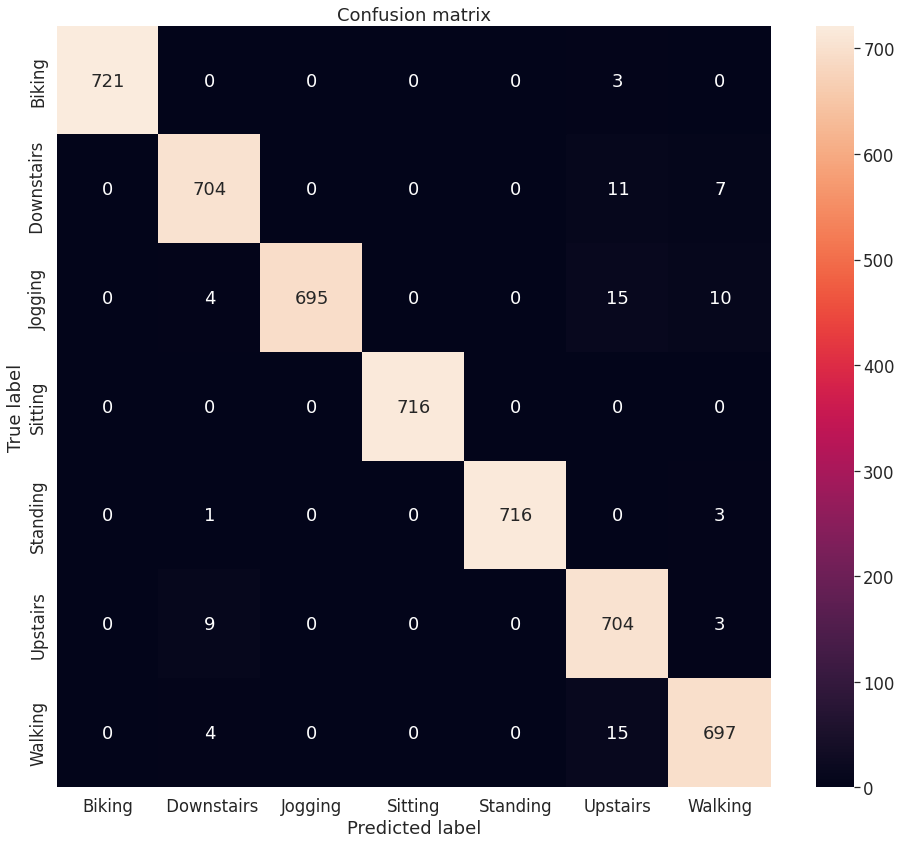

In [19]:
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

LABELS = ['Biking' ,' Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

plt.figure(figsize=(16, 14))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();


## Exporting the model 

a fused TFLite LSTM model

In [20]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 100
INPUT_SIZE = 12
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: keras_lstm/assets


INFO:tensorflow:Assets written to: keras_lstm/assets


In [21]:
# Save the model.
with open('model_LSTM.tflite', 'wb') as f:
  f.write(tflite_model)
  

In [22]:
# Save the model.
with open('model_LSTM_Metadata.tflite', 'wb') as f:
  f.write(tflite_model)
  

**Adding metadata to TensorFlow Lite models**



In [23]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb


In [24]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Human Activity Recognition"
model_meta.description = ("input[None, 100, 3] "
                          "is Sensor "
                          "output['Biking' ,' Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']")
model_meta.version = "v3.100.3"
model_meta.author = "phuoctan4141"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")


In [25]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

input_meta.name = 'inputSensor'
input_meta.description = (
    "Input is array data from sensor with 100steps".format(100, 3))
input_stats = _metadata_fb.StatsT()
input_meta.stats = input_stats


In [26]:
labelmap_file = '/content/labelmap.txt'

export_model_path = '/content/model_LSTM_Metadata.tflite'

In [27]:
import os
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

output_meta.name = "probability"
output_meta.description = "Probabilities of the 7 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(labelmap_file)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]


In [28]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()


In [29]:
# Pack metadata and associated files into the model
populator = _metadata.MetadataPopulator.with_model_file(export_model_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([labelmap_file])
populator.populate()


TEST TFLITE

In [38]:
# X_train,X_test, y_train,y_test
# Run the model with TensorFlow to get expected results.
TEST_CASES = 10

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
  expected = model.predict(X_test[i:i+1])
  interpreter.set_tensor(input_details[0]["index"], X_test[i:i+1, :, :])
  interpreter.invoke()
  result = interpreter.get_tensor(output_details[0]["index"])

  # Assert if the result of TFLite model is consistent with the TF model.
  np.testing.assert_almost_equal(expected, result, decimal=5)
  print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

  # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
  # the states.
  # Clean up internal states.
  interpreter.reset_all_variables()

Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
Done. The result of TensorFlow matches the result of TensorFlow Lite.
